# <center>🚀HACK THAT STARTUP VOL.3🚀</center><br> <center>Data Science</center> <br><center>Reto Individual</center>
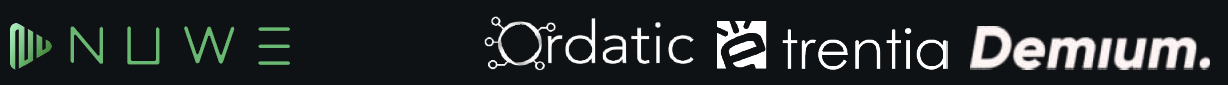

## Información del problema

Actualmente se vive una **nueva carrera espacial** entre naciones y empresas por los **recursos que se hallan en los asteroides cercanos a la tierra**.

Para identificar los asteroides se emplean sondas con infrarrojas que en función del espectro de luz que reflejan permiten saber el tipo de asteroide. Se tienen 4 tipos:
    
    * Tipo C -> Carboniceos (Poseen un alto contenido en agua)
    * Tipo S -> Silicatos
    * Tipo M -> Metálicos (Poseen hierro, Níquel, Oro, Platino, ...)
    * Tipo V -> Acondritas

El problema es que las sondas infrarrojas tienen dificultades para detectar los asteroides de tipo C ya que apenas reflejan la luz.

Por ello se diseñó un **nuevo sensor** que a partir de alteraciones gravitacionales provocadas por los asteroides **reportan 6 características que permiten identificarlos**.

## Tarea

1. Genera un modelo de ML que permita caracterizar los diferentes tipos de asteroides en función de las 6 features del dataset.
2. Evalúala precisión de tu algoritmo calculando el 'F-Score'.

### Dataset

Enlace: [Git Hub de Nuwe.io](https://github.com/nuwe-io/HTS3-DataScience-Individual)<br>
Número de archivos: 1<br>
Nombre del Dataset: asteroid_types.csv<br>
Día del reporte: 29/05/2021<br>
Número de observaciones: 2,000<br>
Número de columnas: 7<br>
Formato base: .csv<br>
Tamaño: 150 KB<br>

### Import packages

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import helpers # custom module
import numpy as np

from sklearn.metrics import precision_recall_fscore_support
import pickle
import math
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import f_regression, mutual_info_regression

# Update default settings

pd.options.display.float_format = '{:.4f}'.format
sns.set(style='darkgrid', context='talk', palette='Set1')

import warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
df = pd.read_csv('asteroid_types.csv')

# Inspect shape of the data and top rows

print(f"{df.shape[0]} rows, {df.shape[1]} columns")
df.head()

2000 rows, 7 columns


Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Classification
0    0.0157   -1.3836    0.8218    1.3149   -0.0718    2.3423               3
1    0.1467    0.7781    0.4867   -0.6972    0.0471    0.6516               2
2    0.0121    1.2993    0.0472    0.7528    0.8984    0.8355               3
3   -0.8479    0.2623   -0.1620    1.0954    0.5499    1.5152               3
4    1.2867    1.9078   -0.3804   -0.1451    0.1113   -0.0766               0

### EDA

Se especifica cuál de las columnas es la variable objetivo y cuáles son las características.

In [3]:
target = 'Classification'
features = df.drop(columns=target).columns

Antes de empezar la exploración de los datos se separan en train y test. Se tomará el 20% de los datos como test set.

Se muestra la distribución de la variable objetivo en train y test.

In [4]:
# Split data into train & test

X_train, X_test, y_train, y_test = helpers.partition(df, target)

# Append target back using indices

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Inspect training data

print(f"Training data ({train.shape[0]} rows): Target distribution")
display(helpers.find_frequency(y_train))
print(f"Test data ({test.shape[0]} rows): Target distribution")
display(helpers.find_frequency(y_test))

Training data (1600 rows): Target distribution


p_frequency  n_frequency
3       0.8500         1360
2       0.1000          160
0       0.0250           40
1       0.0250           40

Test data (400 rows): Target distribution


p_frequency  n_frequency
3       0.8500          340
2       0.1000           40
0       0.0250           10
1       0.0250           10

Se llama al reporte del **análisis inicial** de las variables en el dataset.

In [5]:
train.profile_report()

### EDA conclusiones - 1ra parte:

* Las 6 features son variables contínuas. Todas tienen 1600 valores únicos.
* La variable objetivo es categórica. Tiene 4 valores únicos. 
* **Feature 4 y Feature 5 destacan por su correlación con la variable objetivo**.
* Se tiene correlación entre Feature 6 y Feature 4.
* Se tiene correlación entre Feature 6 y Feature 5.

* No hay missing values.
* Hay un claro **desbalance entre las categorías de la variable objetivo**.

Veamos más de cerca cada una de las variables y su relación con la variable objetivo

In [6]:
# Se definen las features por grupos. En este caso todas las caracteristicas son contínuas.

continuous = train[features]

A continuación se mostrará 4 gráficas por cada una de las features y su relación con la variable target:<br> 
   <blockquote>1. Histograma<br> 
    2. Density plot<br> 
    3. Boxplot<br> 
    4. Swarmplot<br></blockquote>

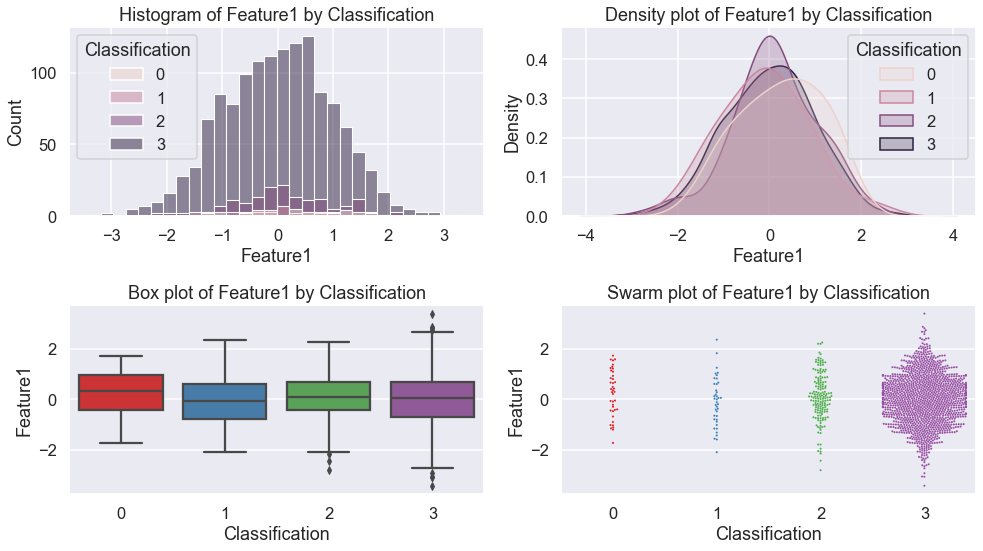

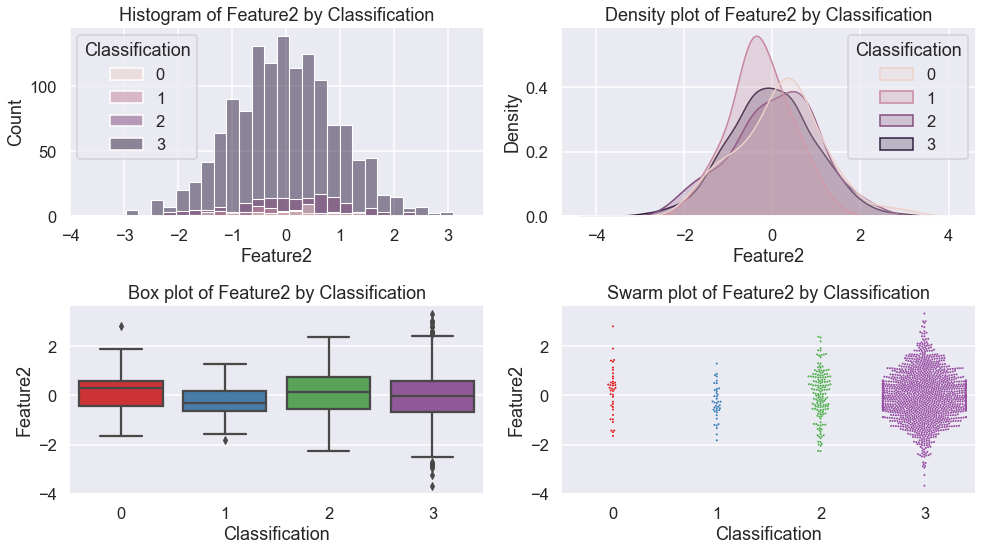

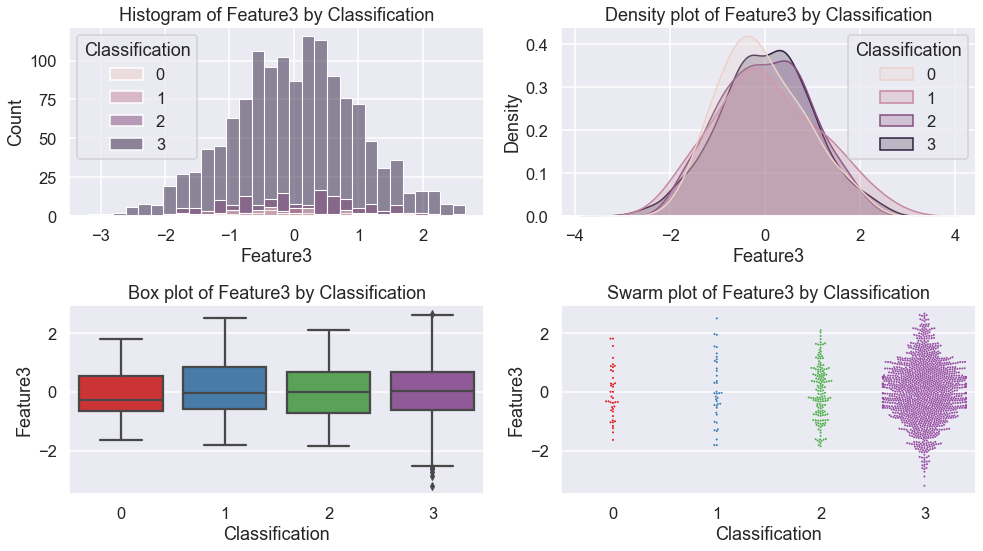

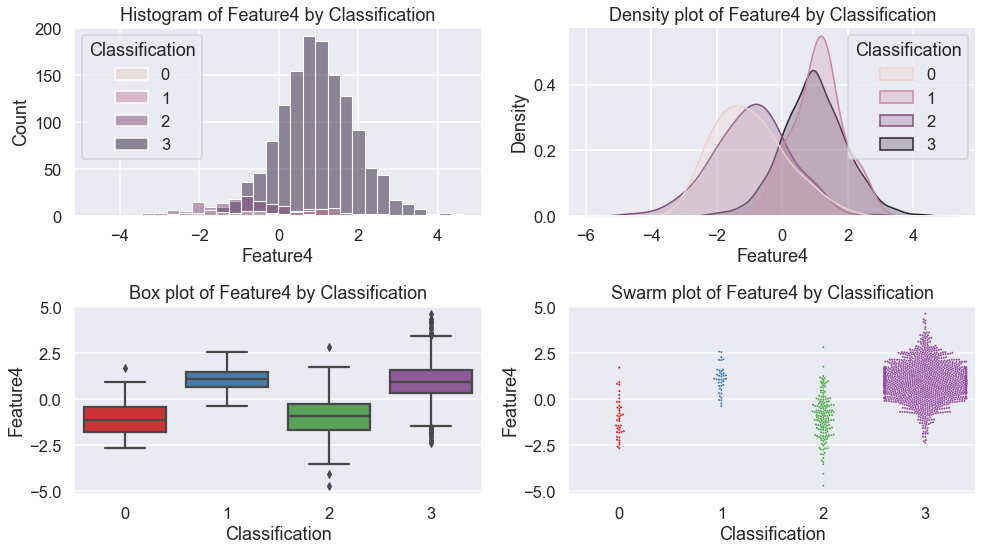

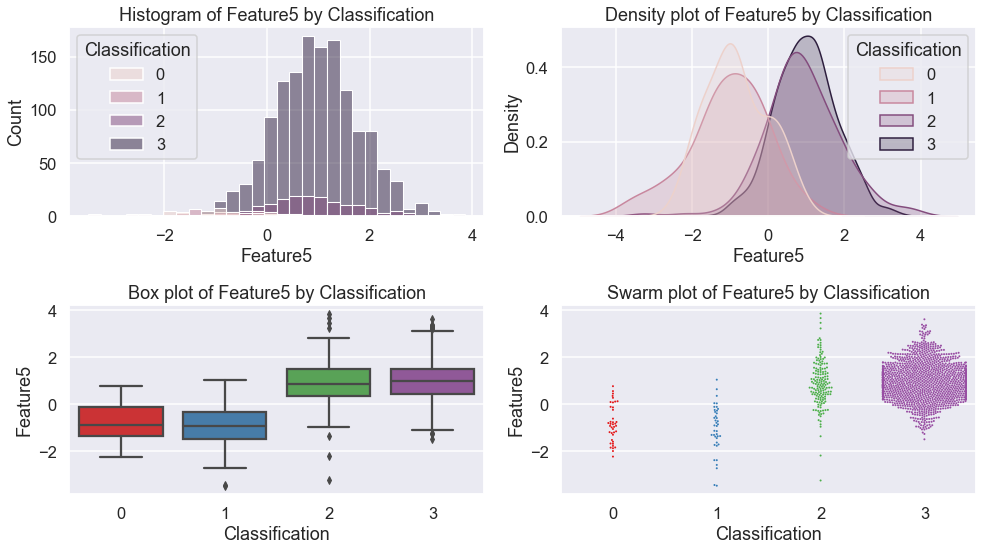

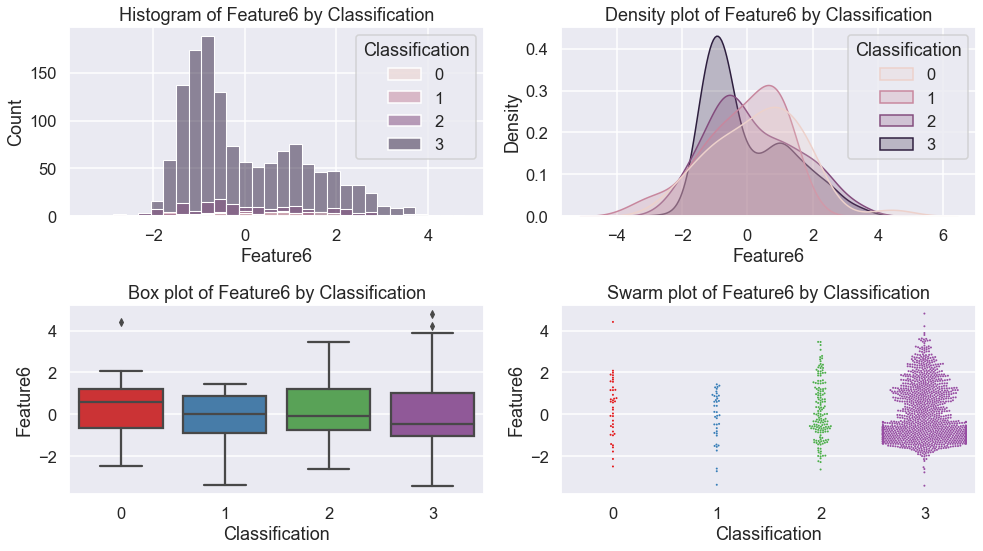

In [7]:
for feature in continuous:
    helpers.plot_continuous(train, feature, target)

### EDA conclusiones - 2da parte

* Se puede ver claramente en los histogramas y swarmplots el desbalance en la variable objetivo. El que se un problema que se tendrá que tratar antes de introducir los datos en un modelo de predicción.
* Puede verse en los gráficos de densidad y en los boxplots que las variables que mejor hacen el trabajo de separar algunas de las clases son feature4 y feature5.

### Feature Engineering

Se construirán otras variables a partir de las seis iniciales con la intención de buscar mejores predictores de la variable objetivo.

In [8]:
train['index1'] = train.index
train.head(3)

Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
1684   -0.2223   -0.8032    0.8377    0.8595    1.6099   -1.3042   
1991    1.8148    1.9678    1.8170    0.9129    1.4344    1.5943   
1413    0.1338   -0.9142   -1.1416    1.4434    0.5398   -1.3846   

      Classification  index1  
1684               3    1684  
1991               3    1991  
1413               3    1413

In [9]:
train_target = train.drop(['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6'], axis='columns', inplace=False)
train_target.head(3)

Classification  index1
1684               3    1684
1991               3    1991
1413               3    1413

Se utiliza la herramienta featuretools que permite combinar las features de manera rápida. En este caso se utilizaron las opciones:<br><blockquote> *'add_numeric',<br>  *'multiply_numeric',<br>  *'divide_numeric'.</blockquote><br>Estas opciones llevan a probar combinaciones de suma, multiplicación y división entre las features iniciales.

Se excluye a la variable objetivo.

In [10]:
import featuretools as ft

# Create Entity
es = ft.EntitySet(id = 'asteroids')
es.entity_from_dataframe(entity_id = 'ast', dataframe = train, index='index1')

# Run deep feature synthesis with transformation primitives
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'ast',
                                      trans_primitives = ['add_numeric', 'multiply_numeric', 'divide_numeric'],ignore_variables={"ast": ["Classification"]},verbose=True)

Built 66 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


Es necesario volver a incluir la variable objetivo en el nuevo dataframe 'feature_matrix' que ahora cuenta con 66 variables.

In [11]:
feature_matrix.shape

(1600, 66)

In [12]:
train_target.shape

(1600, 2)

In [13]:
train_new_features = pd.concat([train_target,feature_matrix], axis=1)

In [14]:
train_new_features.shape

(1600, 68)

In [15]:
train_new_features.drop(['index1'], axis='columns', inplace=True)
train_new_features.head()

Classification  Feature1  Feature2  Feature3  Feature4  Feature5  \
1684               3   -0.2223   -0.8032    0.8377    0.8595    1.6099   
1991               3    1.8148    1.9678    1.8170    0.9129    1.4344   
1413               3    0.1338   -0.9142   -1.1416    1.4434    0.5398   
1537               3    0.1171   -0.8210   -1.5769   -0.4475    0.3421   
332                3   -1.3106    0.2090   -0.9465    0.7034    1.2207   

      Feature6  Feature1 + Feature2  Feature1 + Feature3  Feature1 + Feature4  \
1684   -1.3042              -1.0255               0.6153               0.6371   
1991    1.5943               3.7826               3.6318               2.7277   
1413   -1.3846              -0.7804              -1.0079               1.5771   
1537    1.1343              -0.7039              -1.4598              -0.3304   
332     0.1991              -1.1016              -2.2571              -0.6072   

      ...  Feature2 * Feature3  Feature2 * Feature4  Feature2 * Feature5  \
1684  ...              -0.6728              -0.6903              -1.2931   
1991  ...               3.5754               1.7964               2.8226   
1413  ...               1.0436              -1.3195              -0.4935   
1537  ...               1.2947               0.3674              -0.2809   
332   ...              -0.1978               0.1470               0.2551   

      Feature2 * Feature6  Feature3 * Feature4  Feature3 * Feature5  \
1684               1.0476               0.7200               1.3486   
1991               3.1373               1.6587               2.6063   
1413               1.2657              -1.6478              -0.6163   
1537              -0.9313               0.7057              -0.5395   
332                0.0416              -0.6657              -1.1555   

      Feature3 * Feature6  Feature4 * Feature5  Feature4 * Feature6  \
1684              -1.0925               1.3837              -1.1210   
1991               2.8969               1.3095               1.4554   
1413               1.5807               0.7792              -1.9985   
1537              -1.7886              -0.1531              -0.5076   
332               -0.1884               0.8586               0.1400   

      Feature5 * Feature6  
1684              -2.0997  
1991               2.2869  
1413              -0.7474  
1537               0.3880  
332                0.2430  

[5 rows x 67 columns]

### Selección de características (filtrado)

Para el filtrado se utilizará los métodos de:<br>

<blockquote><b>f_regression</b> (chequea importancia en relaciones lineales)<br>
<b>mutual_info_regression</b> (chequea importancia en relaciones no lineales)</blockquote>

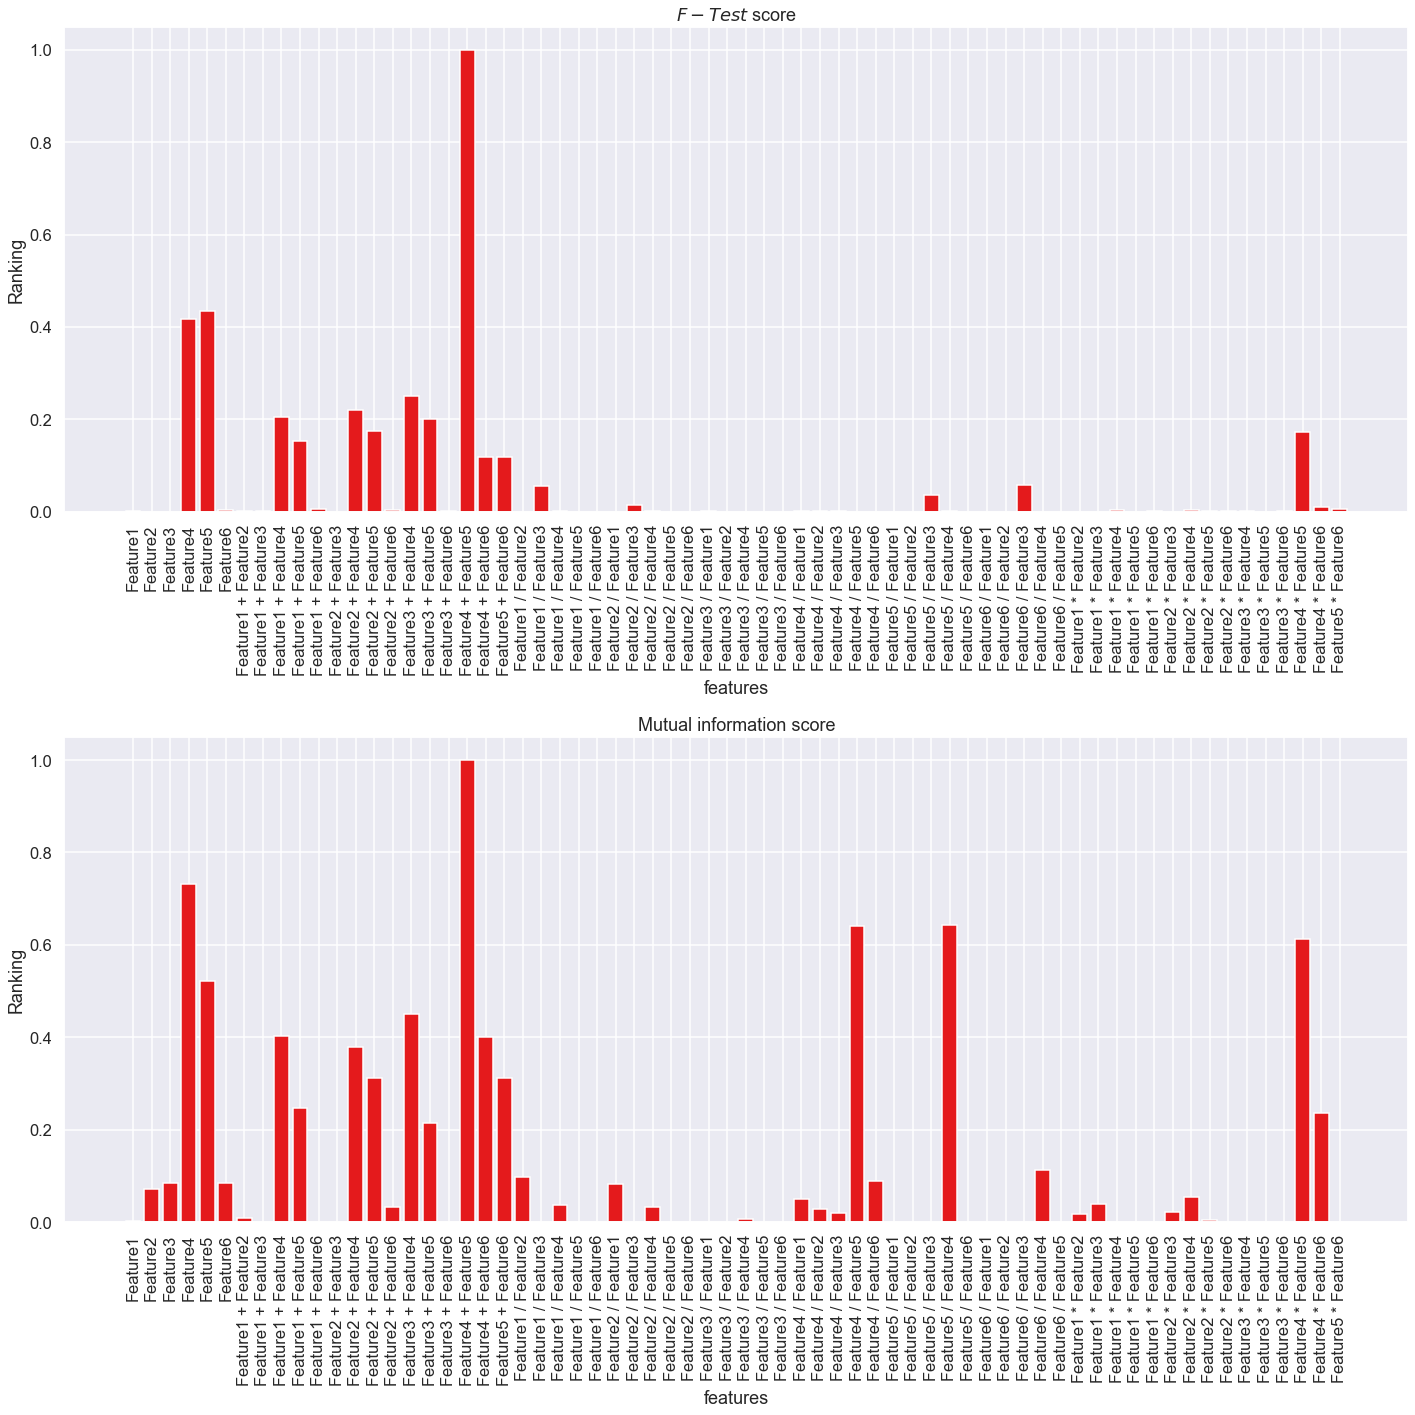

In [16]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = train_new_features.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = train_new_features.columns[1:]


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 20))


plt.subplot(2,1,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(2,1,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.tight_layout() # to avoid some parts of the graphs over others

plt.show()

Las gráficas anteriores muestran la importancia que tienen las variables como predictores de la variable objetivo. A más alta la barra más útil es esta variable. El F - test score capta las relaciones lineales. El Mutual information score capta las relaciones no lineales. Esta información se utilizará en primer lugar para quitar las variables que obtuvieron cero en ambas métricas. Y luego se emplearán estos resultados también para decir qué variable retirar cuando exista correlación entre los predicctores. Lo que se hará más adelante.

In [17]:
train_new_features.columns

Index(['Classification', 'Feature1', 'Feature2', 'Feature3', 'Feature4',
       'Feature5', 'Feature6', 'Feature1 + Feature2', 'Feature1 + Feature3',
       'Feature1 + Feature4', 'Feature1 + Feature5', 'Feature1 + Feature6',
       'Feature2 + Feature3', 'Feature2 + Feature4', 'Feature2 + Feature5',
       'Feature2 + Feature6', 'Feature3 + Feature4', 'Feature3 + Feature5',
       'Feature3 + Feature6', 'Feature4 + Feature5', 'Feature4 + Feature6',
       'Feature5 + Feature6', 'Feature1 / Feature2', 'Feature1 / Feature3',
       'Feature1 / Feature4', 'Feature1 / Feature5', 'Feature1 / Feature6',
       'Feature2 / Feature1', 'Feature2 / Feature3', 'Feature2 / Feature4',
       'Feature2 / Feature5', 'Feature2 / Feature6', 'Feature3 / Feature1',
       'Feature3 / Feature2', 'Feature3 / Feature4', 'Feature3 / Feature5',
       'Feature3 / Feature6', 'Feature4 / Feature1', 'Feature4 / Feature2',
       'Feature4 / Feature3', 'Feature4 / Feature5', 'Feature4 / Feature6',
       'Featur

In [18]:
# se quitan las variables con cero en ambas medidas (F - Test score y MI score)

train_new_features = train_new_features[['Classification', 'Feature2', 'Feature3', 'Feature4','Feature5',
                                        'Feature6', 'Feature1 + Feature2','Feature1 + Feature4', 'Feature1 + Feature5', 
                                        'Feature1 + Feature6', 'Feature2 + Feature4', 'Feature2 + Feature5',
                                        'Feature2 + Feature6', 'Feature3 + Feature4', 'Feature3 + Feature5', 
                                        'Feature4 + Feature5', 'Feature4 + Feature6','Feature5 + Feature6', 
                                        'Feature1 / Feature2', 'Feature1 / Feature3','Feature1 / Feature4', 
                                        'Feature2 / Feature1', 'Feature2 / Feature3', 'Feature2 / Feature4', 
                                        'Feature4 / Feature1', 'Feature4 / Feature2','Feature4 / Feature3', 
                                        'Feature4 / Feature5', 'Feature4 / Feature6', 'Feature5 / Feature3',
                                        'Feature5 / Feature4', 'Feature6 / Feature3', 'Feature6 / Feature4', 
                                        'Feature1 * Feature2', 'Feature1 * Feature3','Feature2 * Feature3', 
                                        'Feature2 * Feature4', 'Feature4 * Feature5', 'Feature4 * Feature6',
                                        'Feature5 * Feature6']]


### Buscamos Columnas con alta correlación entre sí

El modelo no debe contener predictores que tengan correlación alta entre sí. Además la correlación entre features implicaría que se tienen variables redudantes.

In [19]:
train_new_features.corr()

Classification  Feature2  Feature3  Feature4  Feature5  \
Classification               1.0000   -0.0129    0.0093    0.3805    0.3874   
Feature2                    -0.0129    1.0000    0.0150   -0.0049   -0.0005   
Feature3                     0.0093    0.0150    1.0000   -0.0272   -0.0057   
Feature4                     0.3805   -0.0049   -0.0272    1.0000    0.0035   
Feature5                     0.3874   -0.0005   -0.0057    0.0035    1.0000   
Feature6                    -0.0362    0.0137   -0.0150    0.1209   -0.1908   
Feature1 + Feature2         -0.0318    0.7143   -0.0073   -0.0278    0.0093   
Feature1 + Feature4          0.2776    0.0096   -0.0377    0.7624    0.0117   
Feature1 + Feature5          0.2418    0.0146   -0.0222   -0.0226    0.6946   
Feature1 + Feature6         -0.0488    0.0235   -0.0273    0.0770   -0.1460   
Feature2 + Feature4          0.2861    0.6339   -0.0115    0.7703    0.0024   
Feature2 + Feature5          0.2578    0.7241    0.0069   -0.0012    0.6893   
Feature2 + Feature6         -0.0365    0.6023   -0.0031    0.0936   -0.1526   
Feature3 + Feature4          0.3038    0.0058    0.6227    0.7652   -0.0009   
Feature3 + Feature5          0.2749    0.0105    0.7217   -0.0173    0.6881   
Feature4 + Feature5          0.5376   -0.0042   -0.0249    0.7874    0.6191   
Feature4 + Feature6          0.2148    0.0065   -0.0277    0.7164   -0.1319   
Feature5 + Feature6          0.2138    0.0120   -0.0172    0.1114    0.4641   
Feature1 / Feature2          0.0013    0.0004   -0.0183    0.0225    0.0043   
Feature1 / Feature3          0.1483   -0.0177    0.0010    0.1046    0.0698   
Feature1 / Feature4         -0.0191    0.0045    0.0103    0.0292    0.0081   
Feature2 / Feature1         -0.0124    0.0455    0.0248   -0.0149    0.0211   
Feature2 / Feature3         -0.0762    0.0596   -0.0003   -0.0075   -0.0616   
Feature2 / Feature4         -0.0170    0.0637   -0.0189   -0.0149    0.0056   
Feature4 / Feature1          0.0213   -0.0137   -0.0144    0.0193   -0.0106   
Feature4 / Feature2          0.0214    0.0076   -0.0288    0.0334    0.0406   
Feature4 / Feature3          0.0268   -0.0021    0.0040    0.0299    0.0575   
Feature4 / Feature5          0.0026   -0.0307   -0.0056    0.0097    0.0010   
Feature4 / Feature6         -0.0149   -0.0030    0.0090    0.0240    0.0150   
Feature5 / Feature3          0.1216   -0.0353    0.0067    0.0587    0.0836   
Feature5 / Feature4          0.0218    0.0146   -0.0037    0.0242    0.0466   
Feature6 / Feature3          0.1503   -0.0094    0.0008    0.1065    0.0576   
Feature6 / Feature4         -0.0031   -0.0041    0.0250   -0.0195   -0.0108   
Feature1 * Feature2          0.0072    0.0466   -0.0039    0.0190    0.0172   
Feature1 * Feature3         -0.0004   -0.0038    0.0032    0.0092   -0.0168   
Feature2 * Feature3         -0.0034   -0.0355   -0.0347   -0.0368    0.0263   
Feature2 * Feature4          0.0341    0.5377   -0.0238   -0.0081    0.0087   
Feature4 * Feature5          0.2555    0.0033   -0.0206    0.6336    0.2945   
Feature4 * Feature6          0.0667   -0.0060   -0.0258    0.2967    0.0162   
Feature5 * Feature6         -0.0459    0.0191    0.0019    0.1989   -0.2272   

                     Feature6  Feature1 + Feature2  Feature1 + Feature4  \
Classification        -0.0362              -0.0318               0.2776   
Feature2               0.0137               0.7143               0.0096   
Feature3              -0.0150              -0.0073              -0.0377   
Feature4               0.1209              -0.0278               0.7624   
Feature5              -0.1908               0.0093               0.0117   
Feature6               1.0000              -0.0003               0.0857   
Feature1 + Feature2   -0.0003               1.0000               0.4409   
Feature1 + Feature4    0.0857               0.4409               1.0000   
Feature1 + Feature5   -0.1408               0.5205               0.4543   
Feature1 + Feature6    0.8005  

Con tantas variables es difícil llegar a una conclusión solo analizando la matriz de correlación, es de ayuda trabajar con un mapa de calor de las correlacione. en el gráfico siguiente a más azul es el cuadrito, es indicador de mayor correlación entre variables.

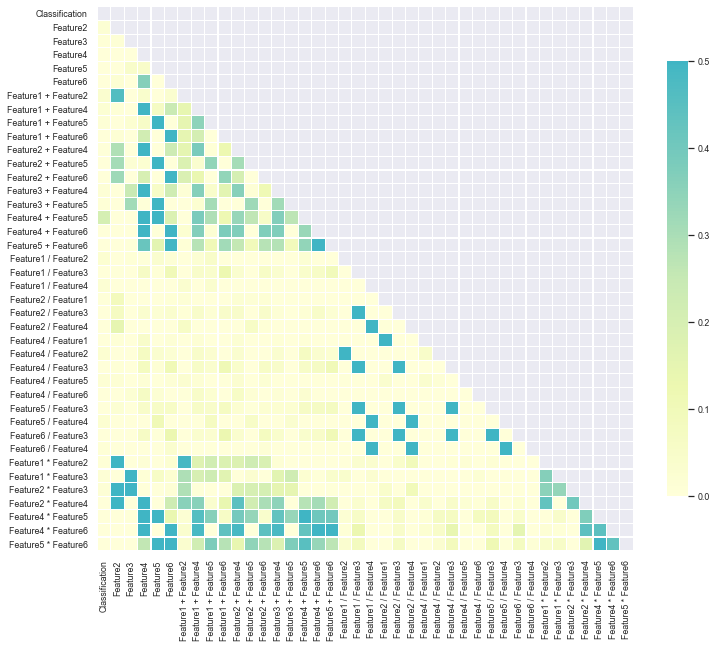

In [20]:
# Compute the correlation matrix

corr = np.abs(train_new_features).corr()

# Generate a mask for the upper triangle

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=0.8) # change font size

# Set up the matplotlib figure

f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=0.5, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Se dejan de lado las variables con alta correlación, seleccionando de entre ellas las que aportan mayor poder predictivo al modelo tomando en cuenta el F Test score y el MI score, obtenidos previamente.

In [21]:
train_new_features = train_new_features[['Classification', 'Feature3', 
                                         'Feature4 + Feature5', 
                                         'Feature1 / Feature2', 'Feature1 / Feature3', 
                                         'Feature2 / Feature1', 'Feature4 / Feature5',
                                         'Feature4 / Feature6','Feature5 / Feature4']]

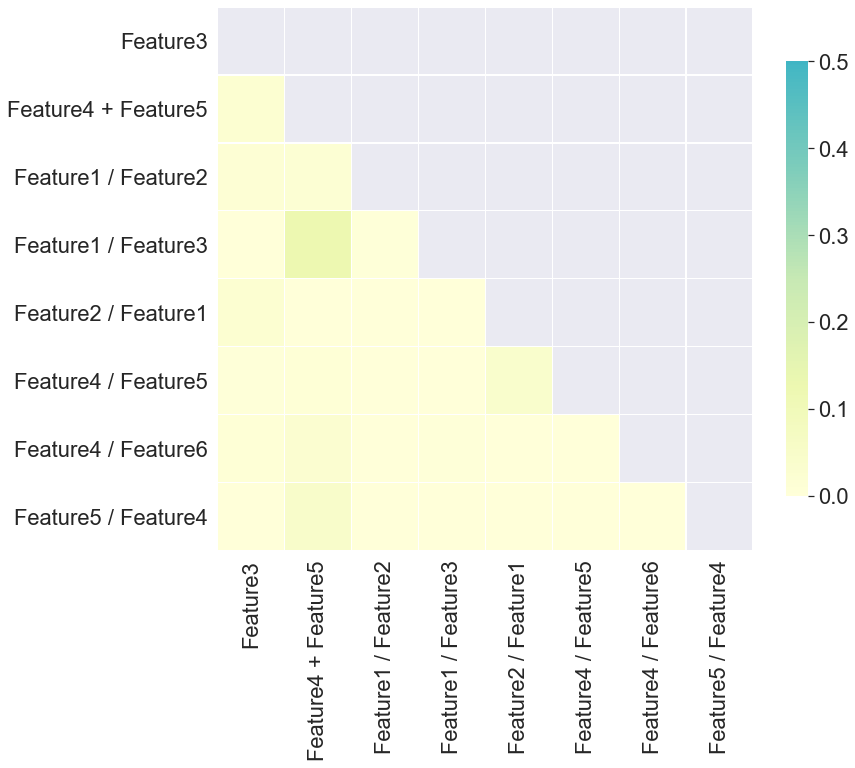

In [22]:
# Compute the correlation matrix

corr = np.abs(train_new_features.drop(['Classification'], axis=1).corr())

# Generate a mask for the upper triangle

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=2) # change font size

# Set up the matplotlib figure

f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=0.5, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Finalmente nos quedamos con 8 features, que fueron seleccionadas para ser incluidas en el modelo de predicción.

### Pre procesado de los datos para introducirse a un Modelo  de clasificación

Se preparan los datos de entrenamiento para introducirse en el modelo.

In [23]:
type(df)

pandas.core.frame.DataFrame

In [24]:
train_new_features.head()

Classification  Feature3  Feature4 + Feature5  Feature1 / Feature2  \
1684               3    0.8377               2.4694               0.2768   
1991               3    1.8170               2.3473               0.9223   
1413               3   -1.1416               1.9832              -0.1463   
1537               3   -1.5769              -0.1054              -0.1427   
332                3   -0.9465               1.9241              -6.2706   

      Feature1 / Feature3  Feature2 / Feature1  Feature4 / Feature5  \
1684              -0.2654               3.6123               0.5339   
1991               0.9988               1.0843               0.6364   
1413              -0.1172              -6.8344               2.6738   
1537              -0.0743              -7.0101              -1.3081   
332                1.3846              -0.1595               0.5762   

      Feature4 / Feature6  Feature5 / Feature4  
1684              -0.6590               1.8731  
1991               0.5726               1.5713  
1413              -1.0424               0.3740  
1537              -0.3945              -0.7645  
332                3.5332               1.7356

Como se mencionó al final de EDA, es necesario balancear las categorías en la variable objetivo. Para ello se emplea la tecnica de SMOTE para remuestrear las categorías sub representadas.

Class=3, n=1360 (25.000%)
Class=2, n=1360 (25.000%)
Class=0, n=1360 (25.000%)
Class=1, n=1360 (25.000%)


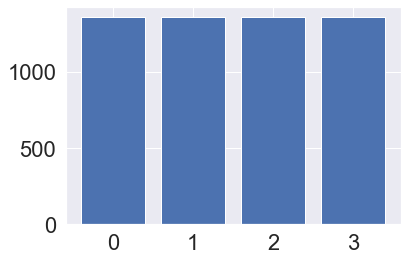

In [25]:
data = train_new_features

# split into input and output elements

X, y = train_new_features[train_new_features.columns.difference(['Classification'])], train_new_features.iloc[:, 0]

# label encode the target variable

y = LabelEncoder().fit_transform(y)

# transform the dataset

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution

counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution

plt.bar(counter.keys(), counter.values())
plt.show()

## SVM Model

Luego de testear algunas alternativas, se llegó a que el modelo que genera mejores prestación es un SVM.

In [27]:
X

Feature1 / Feature2  Feature1 / Feature3  Feature2 / Feature1  Feature3  \
0                  0.2768              -0.2654               3.6123    0.8377   
1                  0.9223               0.9988               1.0843    1.8170   
2                 -0.1463              -0.1172              -6.8344   -1.1416   
3                 -0.1427              -0.0743              -7.0101   -1.5769   
4                 -6.2706               1.3846              -0.1595   -0.9465   
...                   ...                  ...                  ...       ...   
5435               1.1340               1.4743               0.9401    0.6144   
5436              -0.9094              -0.8946              -1.1187    1.1302   
5437               0.8971              -0.5553               1.1217    0.8686   
5438               0.0372               0.0490              31.2669   -0.6519   
5439               1.0364             -16.9066               1.6583    0.0204   

      Feature4 + Feature5  Feature4 / Feature5  Feature4 / Feature6  \
0                  2.4694               0.5339              -0.6590   
1                  2.3473               0.6364               0.5726   
2                  1.9832               2.6738              -1.0424   
3                 -0.1054              -1.3081              -0.3945   
4                  1.9241               0.5762               3.5332   
...                   ...                  ...                  ...   
5435              -0.1562              -1.1452               1.5066   
5436               0.3586               1.2245              -0.1671   
5437              -0.5103              -2.3935              -1.4519   
5438              -0.1825              -1.0928               0.5738   
5439              -1.1077              -1.8058              -0.6790   

      Feature5 / Feature4  
0                  1.8731  
1                  1.5713  
2                  0.3740  
3                 -0.7645  
4                  1.7356  
...                   ...  
5435              -0.8754  
5436               0.8723  
5437              -0.4202  
5438              -0.9277  
5439              -0.6572  

[5440 rows x 8 columns]

Se escalan los datos de entrenamiento.

In [28]:
scaler = preprocessing.StandardScaler().fit(X)
XtrainScaled = scaler.transform(X)

Se emplea gridsearch para encontrar los mejores parámetros. CV = 3, permite correr el modelo en menos de una hora. n_jobs permite ejecutar los jobs con tantos workers como sea posible. En el presente caso 8.

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 11.0min finished


best mean cross-validation score: 0.903
best parameters: {'C': 23.95026619987486, 'gamma': 10.0}


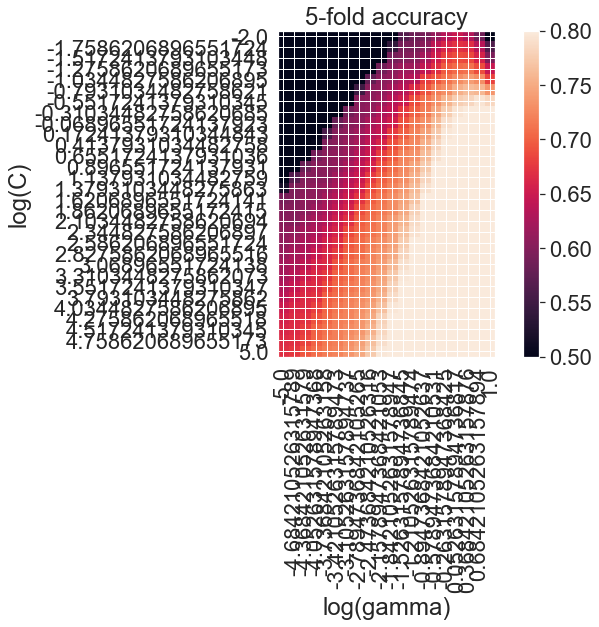

In [29]:
# Paso 2

vectorC = np.logspace(-2, 5, 30)
vectorG = np.logspace(-5, 1, 20)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv = 3, verbose=3, n_jobs=-1)
grid.fit(XtrainScaled, y)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV

scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.5, vmax=0.8)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

Se imprimen los parámetros encontrados como óptimos

In [30]:
print(f'C = {math.log10(grid.best_params_["C"])}, gamma = {math.log10(grid.best_params_["gamma"])}')

C = 1.3793103448275863, gamma = 1.0


In [31]:
# Paso 3

Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

# Se ajusta el modelo a los datos de entrenamiento con los parámetros obtenidos

svmModel2 = SVC(kernel='rbf',gamma = Gopt, C = Copt).fit(XtrainScaled, y)

In [32]:
# Se guarda el modelo

filename = 'finalized_SVM_model_2.sav'
pickle.dump(svmModel2, open(filename, 'wb'))

### Tratamos los datos de test

Para evaluar el modelo es necesario utilizar los datos de test que reservamos antes de EDA y hacerlo pasar por las mismas transformaciones que sufrió el conjunto de train.

In [33]:
test.head()

Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
237    -0.6843   -0.0585   -1.4040    0.7679   -0.1493    0.0236   
1776    0.0565    1.2909   -0.7239    0.0355    0.9293   -0.8916   
1649   -1.1196    0.2431    1.4660    0.8803    1.3017    0.3460   
1687   -1.4148   -0.6045   -0.4803   -0.4060    0.6132   -1.8984   
353     0.5949    0.5227    0.4186    1.1421    0.1580   -0.2513   

      Classification  
237                2  
1776               3  
1649               3  
1687               2  
353                3

In [34]:
test['Feature4 + Feature5'] =  test['Feature4'] + test['Feature5']
test['Feature1 / Feature2'] =  test['Feature1'] / test['Feature2']
test['Feature1 / Feature3'] =  test['Feature1'] / test['Feature3']
test['Feature2 / Feature1'] =  test['Feature2'] / test['Feature1']
test['Feature4 / Feature5'] =  test['Feature4'] / test['Feature5']
test['Feature4 / Feature6'] =  test['Feature4'] / test['Feature6']
test['Feature5 / Feature4'] =  test['Feature5'] / test['Feature4']

test.drop(['Feature1', 'Feature2', 'Feature4', 'Feature5', 'Feature6'],  axis='columns', inplace=True)

column_names = ['Classification', 'Feature3', 'Feature4 + Feature5',
       'Feature1 / Feature2', 'Feature1 / Feature3', 'Feature2 / Feature1',
       'Feature4 / Feature5', 'Feature4 / Feature6', 'Feature5 / Feature4']

test = test.reindex(columns=column_names)

test.columns

Index(['Classification', 'Feature3', 'Feature4 + Feature5',
       'Feature1 / Feature2', 'Feature1 / Feature3', 'Feature2 / Feature1',
       'Feature4 / Feature5', 'Feature4 / Feature6', 'Feature5 / Feature4'],
      dtype='object')

In [35]:
X_test, y_test = train_new_features[train_new_features.columns.difference(['Classification'])], train_new_features.iloc[:, 0]

y_test = LabelEncoder().fit_transform(y_test)

Se escalan los datos en test con el scaler obtenido de escalar los datos en train.

In [36]:
XtestScaled = scaler.transform(X_test)

Se obtiene el **accuracy** del modelo en los datos de Test

In [37]:
print('Acc (TEST): %0.2f'%svmModel2.score(XtestScaled, y_test))

Acc (TEST): 0.99


### Predicción

In [38]:
y_pred = svmModel2.predict(XtestScaled)

In [39]:
# calculo de f score

precision, recall, Fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

### Precision, Recall, F score

Las especificaciones de la Hackathon indican que el modelo debe testearse con el F - Score macro.

In [40]:
print('Precision: %0.3f'%precision)
print('Precision: %0.3f'%recall)
print('Precision: %0.3f'%Fscore)

Precision: 0.978
Precision: 0.998
Precision: 0.988
